# Nelder-Mead Homework
#### Кокряшкин Максим, Б05-932

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from scipy.optimize import minimize

%matplotlib notebook

Зададим исходную функцию

$
f(x, y) = \sin(y) e^{(1- \cos(x))^2} + \cos(x) e^{(1- \sin(y))^2}
    + (x-y)^2
$

через numpy.

In [2]:
def function(args):
    """
    Python implementation of function
    f(x, y) = \sin(y) e^{(1- \cos(x))^2} + \cos(x) e^{(1- \sin(y))^2} +
    + (x-y)^2
    
    Takes an iterable consisting of at least two elements (x and y)
    and calculates value from those args.
    
    Support broadcasting
    """
   
    x = args[0]
    y = args[1]
    
    sin_term = np.sin(y) * np.exp(np.square(1 - np.cos(x)))
    cos_term = np.cos(x) * np.exp(np.square(1 - np.sin(y)))
    sq_term = np.square(x - y)
    
    return sin_term + cos_term + sq_term

Реализуем оптимайзер с опцией выгрузки сиплексов для визуализации. Описание взято из: https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method#:~:text=The%20Nelder%E2%80%93Mead%20method%20

In [3]:
class NelderMeadOptimizer:
    def __init__(self, func, tolerance, alpha=1, gamma=2, rho=0.5, sigma=0.5):

        self.func = func
        self.tolerance = tolerance
        self.alpha = alpha
        self.gamma = gamma
        self.rho = rho
        self.sigma = sigma
    
    def __check_terminate(self):
        if np.std(self.func(self.simplex)) < self.tolerance:
            return True
        return False
    
    def __centroid(self):
        return np.mean(self.simplex[:, :-1], axis=1)
    
    def __order(self):
        self.simplex = self.simplex[:, np.argsort(self.func(self.simplex))]
    
    def __reflection(self, reflected):
        best = self.simplex[:, 0]
        second_worst = self.simplex[:, -2]
        
        if self.func(best) <= self.func(reflected) < self.func(second_worst):
            self.simplex[:, -1] = reflected
            return True
        return False
    
    def __expansion(self, reflected, centroid):
        best = self.simplex[:, 0]
        
        if self.func(reflected) < self.func(best):
            expanded = centroid + self.gamma * (reflected - centroid)
            self.simplex[:, -1] = expanded if self.func(expanded) < self.func(reflected) else reflected
            return True
        return False
    
    def __contraction(self, reflected, centroid):
        second_worst = self.simplex[:, -2]
        worst = self.simplex[:, -1]
        
        if self.func(reflected) >= self.func(second_worst):
            contracted = centroid + self.rho * (worst - centroid)
            if self.func(contracted) < self.func(worst):
                self.simplex[:, -1] = contracted
                return True
        return False
    
    def __shrink(self):
        best = self.simplex[:, 0]
        self.simplex = (best + self.sigma * (self.simplex.T - best)).T
    
    def optimize(self, simplex, return_simplexes=False):
        self.simplex = simplex
        
        if return_simplexes:
            self.simplexes = []
        
        while not self.__check_terminate():
            if return_simplexes:
                self.simplexes.append(self.simplex)
            
            self.__order()
            centroid = self.__centroid()
            worst = self.simplex[:, -1]
            reflected = centroid + self.alpha * (centroid - worst)
        
            if self.__reflection(reflected):
                continue
            if self.__expansion(reflected, centroid):
                continue
            if self.__contraction(reflected, centroid):
                continue
            self.__shrink()
            
        return self.simplex[:, 0], self.simplexes

Проверим, что оптимайзер работает

In [4]:
optimizer = NelderMeadOptimizer(function, 0.01)
result, simplexes = optimizer.optimize(np.array([[0.0, 0.0], [11.0, 0.0], [0.0, 11.0]]).T.astype(np.float64), True)
print(result)

[3.16041843 4.70693346]


Визуализируем схождение алгоритма

<IPython.core.display.Javascript object>


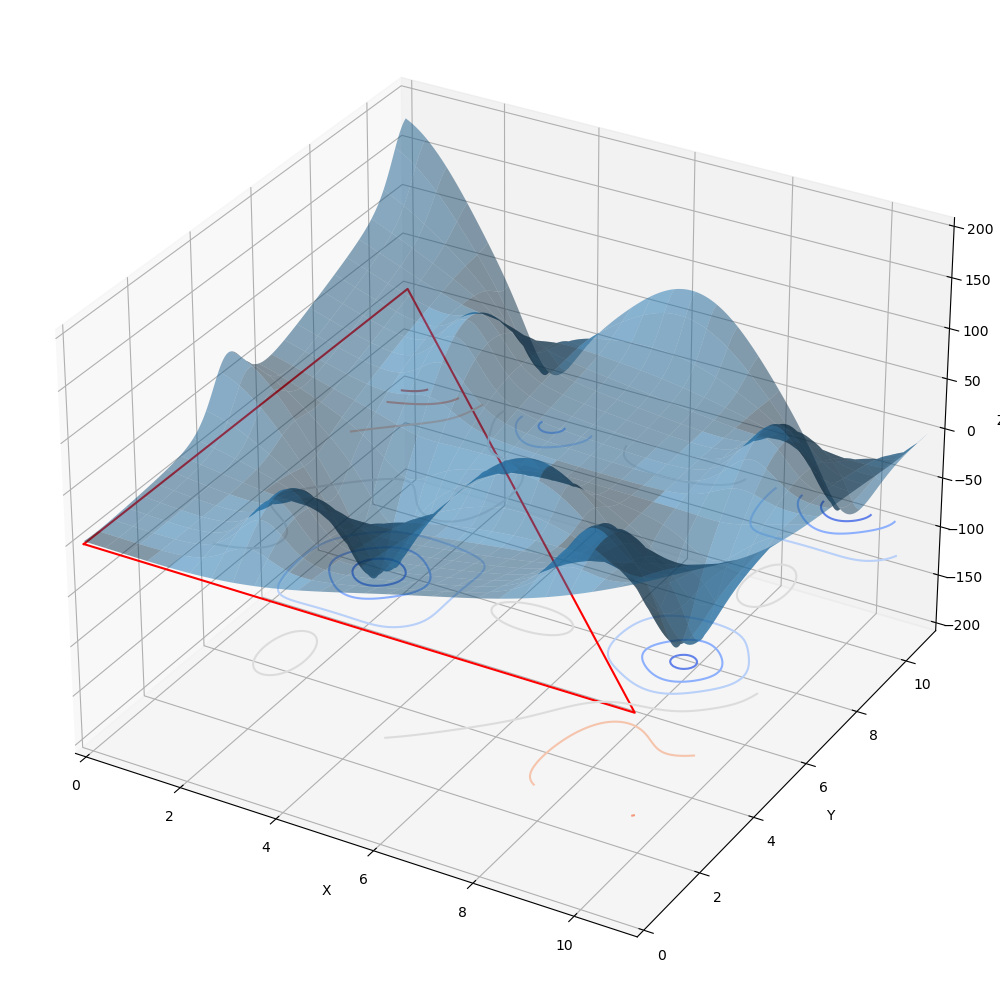

/tmp/ipykernel_772317/3659891957.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


In [5]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
X = np.linspace(0, 11, 200)
Y = np.linspace(0, 11, 200)
X, Y = np.meshgrid(X, Y)
Z = function(np.array([X, Y]))

ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.5, label='Function')

simplex = simplexes[0]
simplex = np.append(simplex, np.array([simplex[:, 0]]).T, axis=1)
simplex_plot, = ax.plot(simplex[0], simplex[1], np.zeros(len(simplex[0])), color='red', label='Simplex')
ax.set_xlim(0, 11)
ax.set_ylim(0, 11)
ax.set_zlim(-200, 200)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Nelder-Mead optimization")


def update(frame, simplex_plot, simplexes):
    simplex = simplexes[frame]
    simplex = np.append(simplex, np.array([simplex[:, 0]]).T, axis=1)
    #ax.plot(simplex[0], simplex[1])
    func_value = function(simplex)
    simplex_plot.set_data(simplex[0], simplex[1])
    simplex_plot.set_3d_properties(func_value)
    return simplex_plot


# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph
ani = FuncAnimation(fig, update, frames=len(simplexes), fargs=(simplex_plot, simplexes), blit=True)
plt.show()

Видно, что мы действительно сошлись к точке локального минимума. Теперь попробуем поменять начальный сиплекс и оценим изменения

In [6]:
result, simplexes = optimizer.optimize(np.array([[11.0, 11.0], [11.0, 0.0], [0.0, 11.0]]).T.astype(np.float64), True)
print(result)

[9.40237564 4.75245711]


Результат действительно изменился. Визуализируем его.

<IPython.core.display.Javascript object>


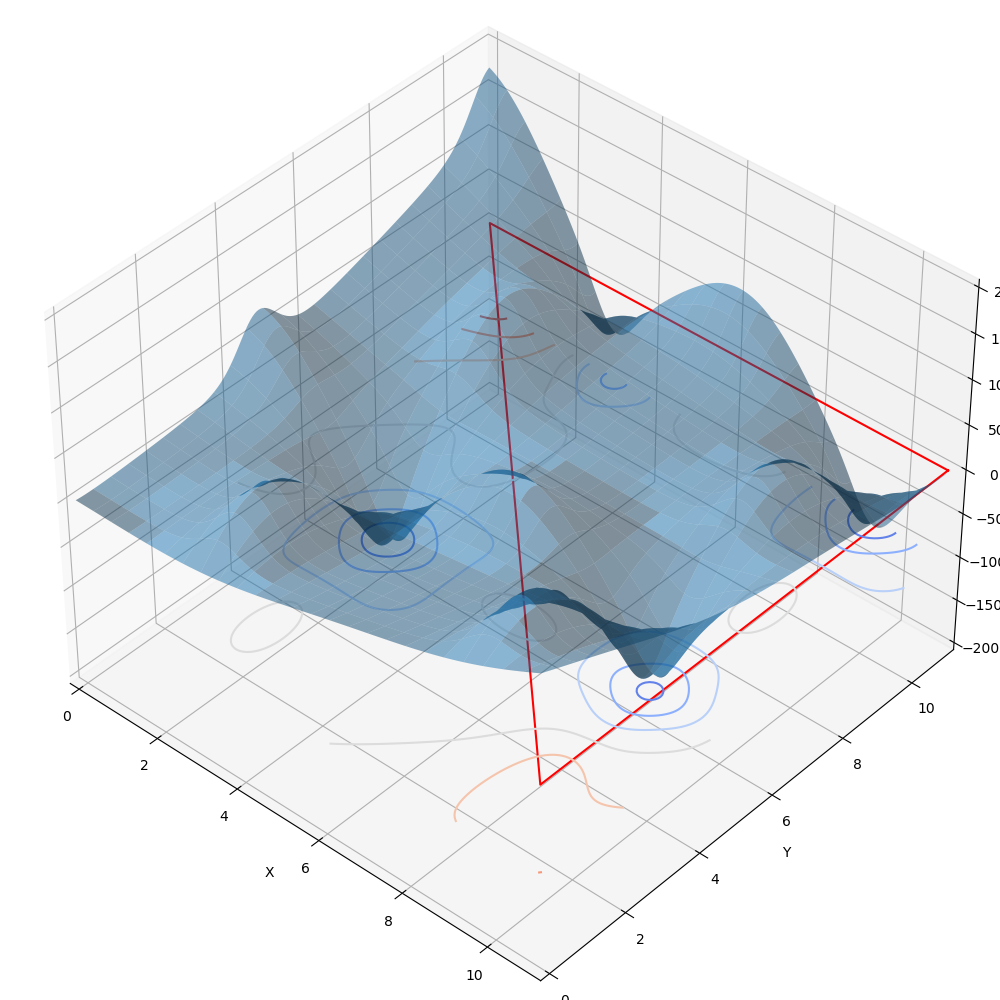

/tmp/ipykernel_772317/3659891957.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/usr/lib/python3.9/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


In [7]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
X = np.linspace(0, 11, 200)
Y = np.linspace(0, 11, 200)
X, Y = np.meshgrid(X, Y)
Z = function(np.array([X, Y]))

ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.5, label='Function')

simplex = simplexes[0]
simplex = np.append(simplex, np.array([simplex[:, 0]]).T, axis=1)
simplex_plot, = ax.plot(simplex[0], simplex[1], np.zeros(len(simplex[0])), color='red', label='Simplex')
ax.set_xlim(0, 11)
ax.set_ylim(0, 11)
ax.set_zlim(-200, 200)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Nelder-Mead optimization")


def update(frame, simplex_plot, simplexes):
    simplex = simplexes[frame]
    simplex = np.append(simplex, np.array([simplex[:, 0]]).T, axis=1)
    #ax.plot(simplex[0], simplex[1])
    func_value = function(simplex)
    simplex_plot.set_data(simplex[0], simplex[1])
    simplex_plot.set_3d_properties(func_value)
    return simplex_plot


# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph
ani = FuncAnimation(fig, update, frames=len(simplexes), fargs=(simplex_plot, simplexes), blit=True)
plt.show()

Можно заключить, что начальный сиплекс очень важен. Если взять слишком маленький сиплекс, то можно сойтись к очень локальному экстремуму, что не всегда бывает полезно. Тем не менее, это может быть полезным инструментом в других ситуациях.

Посмотрим, что будет, если взять последнюю начальную точку и изменить набор гиперпараметров

In [8]:
optimizer = NelderMeadOptimizer(function, 0.01, 0.5, 3, 0.2, 3)
result, simplexes = optimizer.optimize(np.array([[11.0, 11.0], [11.0, 0.0], [0.0, 11.0]]).T.astype(np.float64), True)
print(result)

[ 9.44016769 10.99303975]


Видно, что алгоритм сошелся к совершенно другой точке, несмотря на тот же стартовый симплекс

<IPython.core.display.Javascript object>


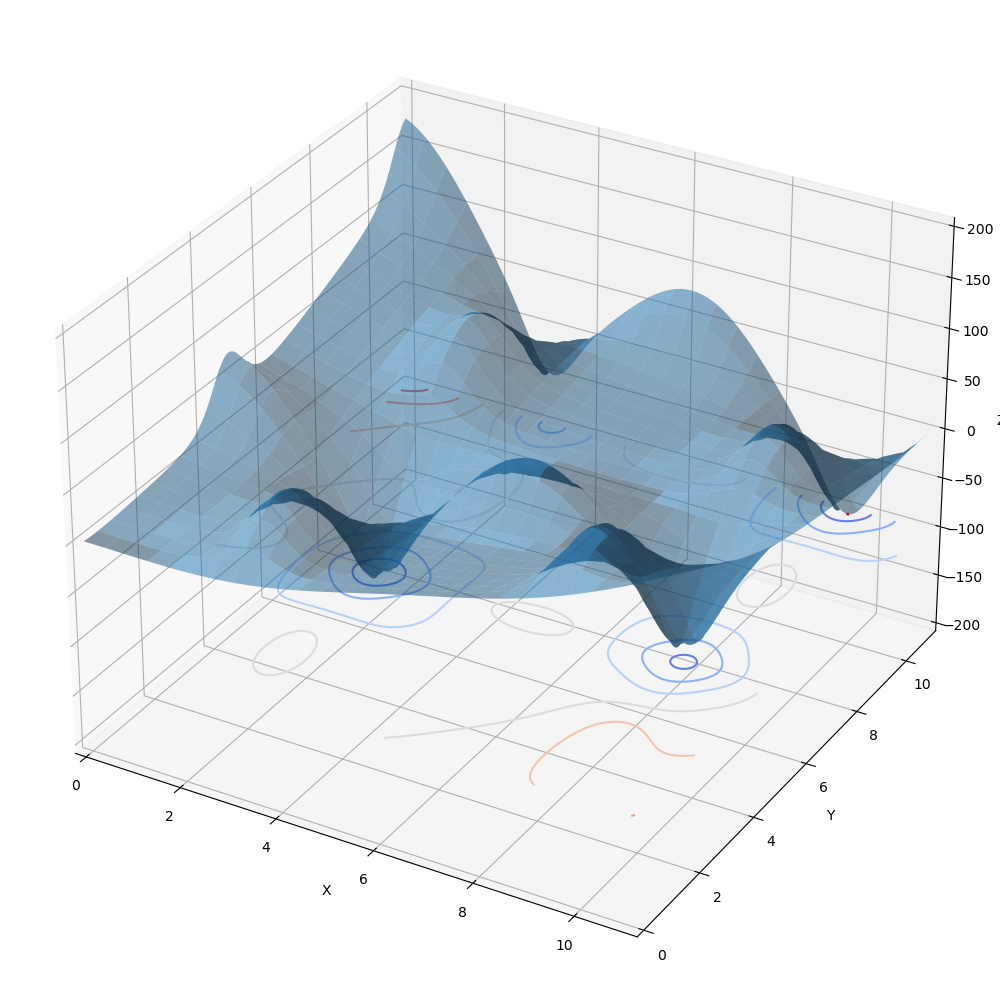

/tmp/ipykernel_772317/3659891957.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/usr/lib/python3.9/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


In [9]:
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
X = np.linspace(0, 11, 200)
Y = np.linspace(0, 11, 200)
X, Y = np.meshgrid(X, Y)
Z = function(np.array([X, Y]))

ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.5, label='Function')

simplex = simplexes[0]
simplex = np.append(simplex, np.array([simplex[:, 0]]).T, axis=1)
simplex_plot, = ax.plot(simplex[0], simplex[1], np.zeros(len(simplex[0])), color='red', label='Simplex')
ax.set_xlim(0, 11)
ax.set_ylim(0, 11)
ax.set_zlim(-200, 200)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Nelder-Mead optimization")


def update(frame, simplex_plot, simplexes):
    simplex = simplexes[frame]
    simplex = np.append(simplex, np.array([simplex[:, 0]]).T, axis=1)
    #ax.plot(simplex[0], simplex[1])
    func_value = function(simplex)
    simplex_plot.set_data(simplex[0], simplex[1])
    simplex_plot.set_3d_properties(func_value)
    return simplex_plot


# Plot projections of the contours for each dimension.  By choosing offsets
# that match the appropriate axes limits, the projected contours will sit on
# the 'walls' of the graph
ani = FuncAnimation(fig, update, frames=len(simplexes), fargs=(simplex_plot, simplexes), blit=True)
plt.show()

Можно заключить, что и стартовый симплекс, и гиперпараметры оказывают огромное влияние на итоговую точку минимума. Изменение параметров может привести даже к тому, что алгоритм сойдется к значению, не являющемуся минимальным внутри начального симплекса.